In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from IPython.display import clear_output
from PIL import Image

from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image
from tensorflow.python.framework.ops import disable_eager_execution

from google.colab import drive
drive.mount('/content/drive')

logs_path = os.path.join('drive','My Drive','TFG','adversarial_example','logs','attacks')

disable_eager_execution()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
iv3 = InceptionV3()

lemon = 951
shark = 2
llama = 355
beer = 441

96116736/96112376 [==============================] - 1s 0us/step


Input size:  (299, 299, 3)


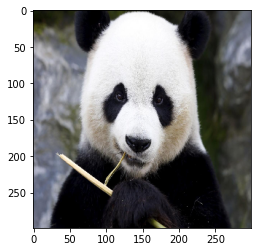

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
40960/35363 [==================================] - 0s 0us/step


[[('n02510455', 'giant_panda', 0.959042),
  ('n04254680', 'soccer_ball', 0.00084733317),
  ('n02509815', 'lesser_panda', 0.0005405632),
  ('n04266014', 'space_shuttle', 0.00041401834),
  ('n13044778', 'earthstar', 0.00026976297)]]

In [ ]:
size = (299,299)

img_path = os.path.join('drive','My Drive','TFG','adversarial_example','panda.jpg')
x = image.img_to_array(image.load_img(img_path, target_size=size))

print("Input size: ", x.shape)

# Save original image in drive
panda = Image.fromarray(np.array(x).astype(np.uint8))
panda.save(os.path.join(logs_path, 'panda.jpg'))

# Show image
plt.imshow(x.astype(np.uint8))
plt.show()

# Cambio de rango => valores entre -1 y 1
x = (x / 255 - 0.5) * 2

# Añadimos el batch_size (bs, h, w, 3)
x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

# Predict image
y = iv3.predict(x)
decode_predictions(y)

# Adversarial attack

Attack execution time:  255


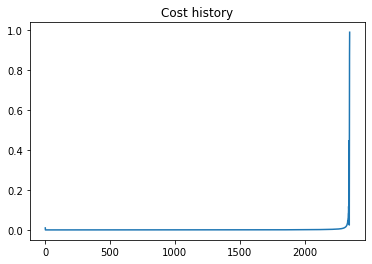

In [ ]:
# Obtenim la forma de les capes d'entrada i sortida de la xarxa
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# Classifiació que volem (de panda a llimona)
target_class = lemon # lemon = 951

# Funció de cost, volem maximitzar la classe llimona
loss = out_layer[0, target_class]

# Utilitzarem el gradinet, no sobre els paràmetres de la xarxa,
# sinó sobre la variable d'entrada (la imatge)
# Volem calcular el gradient entre la funció de cost i les dades d'entrada
grad = K.gradients(loss, inp_layer)[0]

# Funcio que optimitzarà el nostre gradient per obtenir l'input que
# volem per l'atac. Aquestes funcions de Keras demanen els inputs i
# outputs que necessiten.
# El K.learning_phase() s'ha de passar al model quan s'executa per 
# indicar que estem en procés d'entrenament
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

# Variable de cost
cost = 0.0

# Copia de la imatge per no perdre les dades originals
adv = np.copy(x)

# Per que no es notin els canvis en l'input, definim la pertorbació i
# calculem el rang de valors que acceptarem
pert = 0.01

max_pert = x + pert
min_pert = x - pert

# Variables auxiliars
cost_history = np.empty([1])
start = datetime.datetime.utcnow()

# Atac adversari
while cost < 0.95:

  # Obtenim el valor dels píxels (amb el gradient) i el cost
  # Utilitzarem 0 per un mode TEST de learning_phase
  gr, cost = optimize_gradient([adv, 0])

  # Sumem aquest valor a la imatge per alterar-la
  adv += gr

  # Reduïm els canvis a la pertorbació permesa
  adv = np.clip(adv, min_pert, max_pert)
  adv = np.clip(adv, -1, 1)

  print("Target cost: ", cost)
  cost_history = np.append(cost_history, cost)

# Càlucl de temps i outputs
stop = datetime.datetime.utcnow()

clear_output()
print('Attack execution time: ', (stop - start).seconds)

plt.title("Cost history")
plt.plot(cost_history)

logs_path = os.path.join('drive','My Drive','TFG','adversarial_example','logs','attacks')
np.savetxt(os.path.join(logs_path, "attack_lemon.txt"), cost_history, delimiter=",")

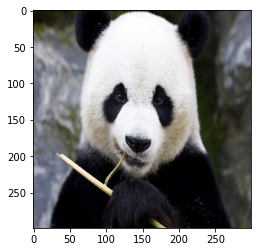

[[('n02823750', 'beer_glass', 0.9990459),
  ('n02510455', 'giant_panda', 0.0001400469),
  ('n03063599', 'coffee_mug', 0.000117438845),
  ('n03443371', 'goblet', 9.48537e-05),
  ('n02815834', 'beaker', 2.5621379e-05)]]

In [ ]:
result = np.copy(adv)

result /= 2
result += 0.5
result *= 255

hacked = Image.fromarray(result[0].astype(np.uint8))
hacked.save(os.path.join(logs_path, 'beer.jpg'))

plt.imshow(result[0].astype(np.uint8))
plt.show()

y = iv3.predict(adv)
decode_predictions(y)